In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Bài tập 1: Ứng dụng ID3 tiến hành dự đoán cho các giá trị trong tập test.**

In [99]:
import pandas as pd 
import numpy as np 
import math

In [100]:
dfdata = pd.read_csv('/content/drive/MyDrive/TH1391_NLMH/Week8_Thuchanh2/Dataset-football-train.txt',sep='\t')
dfdata.head(5) # Hiện chỉ 5 thông tin

,ID,Date,Opponent,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media,Label
0,1,9/5/15,Texas,Home,Out,NBC,Win
1,2,9/12/15,Virginia,Away,Out,ABC,Win
2,3,9/19/15,Georgia Tech,Home,In,NBC,Win
3,4,9/26/15,UMass,Home,Out,NBC,Win
4,5,10/3/15,Clemson,Away,In,ABC,Lose


**Xác định các thuộc tính dữ liệu (lưu ý nó không xác định cột)**

In [101]:
# dfdata=dfdata[['Is_Home_or_Away','Is_Opponent_in_AP25_Preseason','Media','Label']]
data_train = dfdata.iloc[:, 1:]
data_train.head(5)

,Date,Opponent,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media,Label
0,9/5/15,Texas,Home,Out,NBC,Win
1,9/12/15,Virginia,Away,Out,ABC,Win
2,9/19/15,Georgia Tech,Home,In,NBC,Win
3,9/26/15,UMass,Home,Out,NBC,Win
4,10/3/15,Clemson,Away,In,ABC,Lose


In [102]:
# Tạo thuộc tính
attrs = [list(dfdata.columns[1:])] # Dùng header để lấy thuộc tính # ['Is_Home_or_Away','Is_Opponent_in_AP25_Preseason','Media','Label']
attrs

[['Date',
  'Opponent',
  'Is_Home_or_Away',
  'Is_Opponent_in_AP25_Preseason',
  'Media',
  'Label']]

**Xây dựng class Tree**


In [103]:
class Tree:
  def __init__(self,observationIDs,features,currLvl=0,subTree={},bestFeature=None,majorityLabel=None,parentMajorityLabel=None):
    self.observationIDs = observationIDs
    self.features = features
    self.currLvl = currLvl
    self.subTree = subTree
    self.bestFeature = bestFeature
    self.majorityLabel = majorityLabel
    self.parentMajorityLabel = parentMajorityLabel
    self.setBestFeatureID(bestFeature)
    
  def setBestFeatureID(self, feature): # Chon5 thuoc tinh tot nhat
    idx = None
    if feature == 'Is_Home_or_Away':
      idx = 0
    elif feature == 'Is_Opponent_in_AP25_Preseason':
      idx = 1
    else:
      idx = 2
    self.bestFeatureID = int(idx)

**Xây dựng hàm dự đoán**

In [104]:
def predict(tree, obs): # đư đoán dữ lieu bat ky
	if tree.bestFeature == None:
		return tree.majorityLabel
	featVal = obs[tree.bestFeatureID]
	if not featVal in tree.subTree: # val with no subtree
		return tree.majorityLabel
	else: # recurse on subtree
		return predict(tree.subTree[featVal],obs)

**Hàm hiển thị cây**

In [105]:
def displayDecisionTree(tree):
	print('\t'*tree.currLvl + '(lvl {}) {}'.format(tree.currLvl,tree.majorityLabel))
	if tree.bestFeature == None:
		return

	print('\t'*tree.currLvl + '{}'.format(tree.bestFeature) + ': ')
	for [val,subTree] in sorted(tree.subTree.items()):
		print('\t'*(tree.currLvl+1) + 'choice: {}'.format(val))
		displayDecisionTree(subTree)

**Hàm tính Entropy**

In [106]:
def Entropy(ns): # Phai tinh toan
	entropy = 0.0
	total = sum(ns)
	for x in ns:
		entropy += -1.0*x/total*math.log(1.0*x/total,2)
	return entropy

**THUẬT TOÁN ID3**
## Hàm tính *Information Gain*

In [107]:
def IG(observationIDs, feature,dfdata):
	# get smaller dataframe
	df = dfdata.loc[list(observationIDs)]
	# populate counts for Wins/Losses for each category of the feature
	labelCountDict = {}
	valueLabelCountDict = {}
	for index, row in df.iterrows():
		label = row['Label'] # !!! Mục tiêu là chổ này
		if not label in labelCountDict:
			labelCountDict[label] = 0 # this specific label was not found so insert 0 count
		labelCountDict[label] += 1
		featureValue = row[feature]
		if not featureValue in valueLabelCountDict:
			valueLabelCountDict[featureValue] = {} # this specific feature value not found so insert empty dict
		if not label in valueLabelCountDict[featureValue]:
			valueLabelCountDict[featureValue][label] = 0 # this specific label was not found for this feature value so insert 0 count
		valueLabelCountDict[featureValue][label] += 1

	ns = []
	for [label,count] in labelCountDict.items():
		ns.append(count)

	H_Y = Entropy(ns)

	H_Y_X = 0.0
	for [featureValue, labelCountDict] in valueLabelCountDict.items():
		nsHYX = []
		for [label,count] in labelCountDict.items():
			nsHYX.append(count)
		H_Y_X += 1.0*sum(nsHYX)/len(df)*Entropy(nsHYX)
	return H_Y - H_Y_X

**THUẬT TOÁN C4.5**

## Hàm tính *Gain Ratio*

In [108]:
def GR(observationIDs, feature, dfdata):
	ig = IG(observationIDs,feature, dfdata)
	if ig == 0:
		return 0
	df = dfdata.loc[list(observationIDs)]
	valueLabelDict = {}
	for index, row in df.iterrows():
		label = row['Label']
		featureValue = row[feature]
		if featureValue not in valueLabelDict:
			valueLabelDict[featureValue] = 0
		valueLabelDict[featureValue] += 1
	ns = []
	for [val,count] in valueLabelDict.items():
		ns.append(count)
	ent = Entropy(ns)
	return float(ig)/ent

**Hàm xây dựng Cây quyết định**

In [109]:
def fillDecisionTree(tree, decisionTreeAlgo, dfdata): 
	# find the majorityLabel
	df = dfdata.loc[list(tree.observationIDs)] # smaller df
	counts = df['Label'].value_counts()
	majorityLabel = df['Label'].value_counts().idxmax()
	if len(counts) > 1:
		if counts['Win'] == counts['Lose']:
			majorityLabel = tree.parentMajorityLabel
	tree.majorityLabel = majorityLabel

	# exit if only one label  # !!! Nhiều cái phân loại thêm vao day
	if len(counts) == 1:
		return
	# exit if no features left
	if len(tree.features) == 0:  
		return

	# find best feature
	featureValueDict = {}
	for feature in tree.features: 
		if decisionTreeAlgo == 'ID3':
			metricScore = IG(tree.observationIDs,feature,dfdata)
		if decisionTreeAlgo == 'C45':
			metricScore = GR(tree.observationIDs,feature,dfdata)
		featureValueDict[feature] = metricScore
	bestFeature, bestFeatureValue = sorted(featureValueDict.items(),reverse=True)[0]
	# exit if IG or GR is 0
	if bestFeatureValue == 0.0:
		return
	tree.bestFeature = bestFeature

	# find subset of features
	subFeatures = set()
	for feature in tree.features:
		if feature == bestFeature: # skip the current best feature
			continue
		subFeatures.add(feature)
	
	# find best feature id # !!! Tự fix
	bestFeatureIdx = 0
	if bestFeature == 'Is_Home_or_Away':
		bestFeatureIdx = 0
	elif bestFeature == 'Is_Opponent_in_AP25_Preseason':
		bestFeatureIdx = 1
	else:
		bestFeatureIdx = 2
	
	# find subset of observations
	subObservationsDict = {}
	for obs in tree.observationIDs:
		val = dfdata.values[obs][bestFeatureIdx]
		if not val in subObservationsDict:
			subObservationsDict[val] = set()
		subObservationsDict[val].add(obs)

	for [val,obs] in subObservationsDict.items():

		tree.subTree[val] = Tree(obs, subFeatures, tree.currLvl + 1,{},None,None,majorityLabel)
		
		fillDecisionTree(tree.subTree[val], decisionTreeAlgo, dfdata)  # Pass 'dfdata' as the third argument

In [118]:
initialObservationIDs = set(range(len(dfdata)))
initialFeatures = set(dfdata.columns[1:])

#Lựa chọn thuật toán

In [111]:
# algoChoice = str(input(("Which decision tree algorithm would you like to use ('ID3' or 'C45)?")))
# if algoChoice not in {'ID3','C45'}:
# 	print("Invalid algorithm choice. You must choose 'ID3' or 'C45'")
# 	exit()
algoChoice = "ID3"
print("choice: {}".format(algoChoice))

choice: ID3


**Hiển thị cây**

In [119]:
MyTree = Tree(initialObservationIDs,initialFeatures)
fillDecisionTree(MyTree, algoChoice, data_train) # In cay ra

print('My Decision Tree:')
displayDecisionTree(MyTree)

My Decision Tree:
(lvl 0) Win
Opponent: 
	choice: Away
	(lvl 1) Lose
	Media: 
		choice: Away
		(lvl 2) Lose
		Label: 
			choice: Away
			(lvl 3) Lose
			Is_Opponent_in_AP25_Preseason: 
				choice: Boston College
				(lvl 4) Win
				choice: Clemson
				(lvl 4) Lose
				choice: North Carolina State
				(lvl 4) Lose
				choice: PITT
				(lvl 4) Win
				choice: Stanford
				(lvl 4) Lose
				choice: Temple
				(lvl 4) Win
				choice: Texas
				(lvl 4) Lose
				choice: USC
				(lvl 4) Lose
				choice: Virginia
				(lvl 4) Win
	choice: Home
	(lvl 1) Win
	Media: 
		choice: Home
		(lvl 2) Win
		Label: 
			choice: Home
			(lvl 3) Win
			Is_Opponent_in_AP25_Preseason: 
				choice: Army
				(lvl 4) Win
				choice: Duke
				(lvl 4) Lose
				choice: Georgia Tech
				(lvl 4) Win
				choice: Miami Florida
				(lvl 4) Win
				choice: Michigan State
				(lvl 4) Lose
				choice: Navy
				(lvl 4) Win
				choice: Nevada
				(lvl 4) Win
				choice: Stanford
				(lvl 4) Lose
				choice: Syracuse
				(lvl 4) 

In [113]:
attrs[:-1]

[]

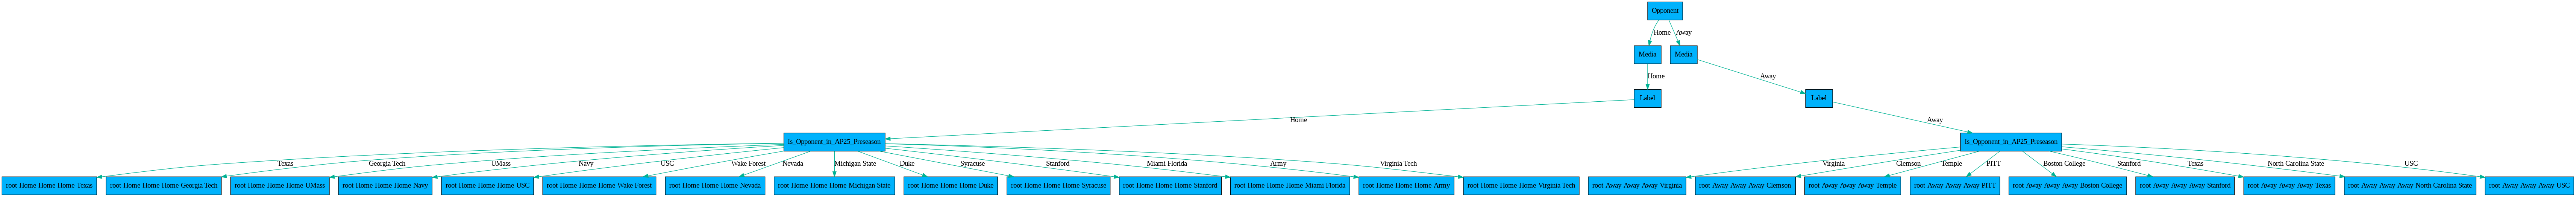

In [120]:
# Vẽ hình
from IPython.display import Image
import pydotplus
import graphviz

def visualize_tree(tree, feature_names=dfdata.columns[1:], class_names=data_train[data_train.columns[-1]].unique(), label='root'):
    if tree.bestFeature is None:
        node_attr = {'shape': 'plaintext', 'style': 'filled', 'fillcolor': 'limegreen'}
        return graphviz.Digraph(node_attr=node_attr, format='png').node(label, f"{tree.majorityLabel}")

    dot = graphviz.Digraph(node_attr={'shape': 'box', 'style': 'filled', 'fillcolor': '#00B2FC'}, format='png')
    dot.node(label, tree.bestFeature)

    for val, sub_tree in tree.subTree.items():
        sub_label = f"{label}-{val}"
        dot.subgraph(visualize_tree(sub_tree, feature_names, class_names, sub_label))
        dot.edge(label, sub_label, label=f"{val}", color='#00B294')

    return dot

dot = visualize_tree(MyTree)
graph = pydotplus.graph_from_dot_data(dot.source)
Image(graph.create_png())

In [115]:
dftest = pd.read_csv('/content/drive/MyDrive/TH1391_NLMH/Week8_Thuchanh2/Dataset-football-test-root.txt', sep='\t')
dftest.head(5)

,ID,Date,Opponent,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media
0,25,9/2/17,Temple,Home,Out,NBC
1,26,9/9/17,Georgia,Home,In,NBC
2,27,9/16/17,BostonCollege,Away,Out,ESPN
3,28,9/23/17,MichiganState,Away,Out,FOX
4,29,9/30/17,MiamiOhio,Home,Out,NBC


In [116]:
# Filter the test DataFrame to only include relevant columns
# data_test = data_test[['Is_Home_or_Away', 'Is_Opponent_in_AP25_Preseason', 'Media']]
data_test = dftest.iloc[:, 3:]
data_test.head(5)

,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media
0,Home,Out,NBC
1,Home,In,NBC
2,Away,Out,ESPN
3,Away,Out,FOX
4,Home,Out,NBC


In [117]:
# Use the ID3 decision tree to predict labels for test data
for index, row in data_test.iterrows():
    obs_row = [row[0], row[1], row[2]]
    pred = predict(MyTree, obs_row)
    print(f'Prediction for {obs_row}: {pred}')

Prediction for ['Home', 'Out', 'NBC']: Win
Prediction for ['Home', 'In', 'NBC']: Win
Prediction for ['Away', 'Out', 'ESPN']: Win
Prediction for ['Away', 'Out', 'FOX']: Win
Prediction for ['Home', 'Out', 'NBC']: Win
Prediction for ['Away', 'Out', 'ABC']: Win
Prediction for ['Home', 'In', 'NBC']: Win
Prediction for ['Home', 'Out', 'NBC']: Win
Prediction for ['Home', 'Out', 'NBC']: Win
Prediction for ['Away', 'In', 'ABC']: Win
Prediction for ['Home', 'Out', 'NBC']: Win
Prediction for ['Away', 'In', 'ABC']: Win
